In [417]:
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io.processing_api import SentinelHubInputTask
from eolearn.core import LoadTask, SaveToDisk, AddFeature, RemoveFeature
from eolearn.visualization import EOPatchVisualization
from eolearn.mask import AddValidDataMaskTask
from shapely.ops import cascaded_union
from shapely.geometry import Polygon

from eolearn.features import SimpleFilterTask, NormalizedDifferenceIndexTask

from eolearn.geometry import VectorToRaster
import geopandas as gpd
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sentinelhub as sh
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Configuration of SentinelHub

In [418]:
config = sh.SHConfig()
config.sh_client_id= r'9bd0a46d-3d5b-4dc0-98b5-546b3635f9f3'
config.sh_client_secret = r'~)x%O:RiSc|F5i+SIL}^fZUlWOa.;E^{_:&!J6@:'
config.save()

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### File preparation

In [419]:
path = r'F:\geospatial_datasets\LUCAS_2018_Copernicus\LUCAS_2018_Copernicus'
pt = gpd.read_file(os.path.join(r'F:\geospatial_datasets\portugal_shapefile',r'PRT_adm1.shp'))
gdf = gpd.read_file(os.path.join(path,"LUCAS_2018_Copernicus_polygons.shp"))
csv = pd.read_csv(os.path.join(path,"LUCAS_2018_Copernicus_attributes.csv"))
gdf = gdf.to_crs(sh.CRS.WGS84.pyproj_crs())

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Create Portugal shapefile

In [490]:
portugal_csv = csv#.loc[csv["NUTS0"] == "PT"]
gdf.POINT_ID = gdf.POINT_ID.astype(int)
portugal_gdf = portugal_csv.merge(gdf, on='POINT_ID', how='inner')
portugal_gdf.crs = gdf.crs
portugal_gdf = gpd.GeoDataFrame(portugal_gdf)
portugal_gdf = portugal_gdf.to_crs(sh.CRS.WGS84.pyproj_crs())
portugal_bounds = gpd.GeoSeries(cascaded_union(pt[pt.TYPE_1 == "Distrito"].geometry.to_list()))
portugal_bounds = portugal_bounds.to_crs(sh.CRS.WGS84.pyproj_crs())

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Cannot transform naive geometries.  Please set a crs on the object first.

### Subdivide portugal in smaller bbox

In [421]:

bbox_splitter = sh.BBoxSplitter(portugal_bounds.geometry.to_list(),sh.CRS.WGS84,(100,100))

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [233]:
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_splitter.get_bbox_list()]
gdf_bbox = gpd.GeoDataFrame(crs=portugal_gdf.crs, geometry=geometry)

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Select only bounding boxes that have relevant data

In [234]:
bbox_with_data = []
bbox_with_data = [gdf_bbox[gdf_bbox.geometry.contains(portugal_gdf.geometry[i])] for i,_ in enumerate(portugal_gdf.geometry)]
bbox_with_data = np.concatenate(bbox_with_data).ravel()
bbox_with_data = gpd.GeoDataFrame(geometry=bbox_with_data)
bbox_with_data.crs = portugal_gdf.crs

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Plot the created graphs

In [536]:
fig, ax = plt.subplots(figsize=(400, 400))

gdf_bbox.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.4)

portugal_bounds.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)

portugal_gdf.plot(ax=ax, edgecolor='b')

bbox_with_data.plot(ax=ax, edgecolor='green', facecolor='green', alpha=0.2)
bbox_with_data2.plot(ax=ax, edgecolor='red', facecolor='red', alpha=0.2)


ax.set_title('Bboxes', fontsize=25)

plt.axis('off');
plt.savefig('touches.png')

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Create and prepare EOTasks for the processing the data

In [236]:
class FilterVectorToRaster(EOTask):
    
    def __init__(self,raster_feature,values,raster_resolution):
        #this cant be here still, must add the args to the class and call vector2rastertask in the executemethod
        self.featureType = raster_feature
        self.values = values
        self.raster_resolution = raster_resolution
        
    def execute(self,eopatch,dataset):
        vector = dataset[dataset.geometry.intersects(eopatch.bbox.geometry)]
        print(type(vector))
        for i,vec in vector.iterrows():
            feature_name = self.featureType[-1]+"_"+str(vec.POINT_ID)
            feature = (self.featureType[0], feature_name)
            self.vector2rastertask = VectorToRaster(vector,raster_feature=feature,values=self.values,raster_resolution=self.raster_resolution)
            eopatch = self.vector2rastertask.execute(eopatch)
        return eopatch

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [237]:
def get_time_interval(middle_date, number_of_days):
    """
        Gets the time interval surrounding the middle date separated by slashes
    Args:
        middle_date: A string containing the date which will be included in the timerange
        number_of_days: The number of days counting from the `middle_date` that will correspond to the min and max date
        
    Returns:
        A list with the ´number_of_days´ before and after of the ´middle_date´
        
    Example:
        >>> get_time_interval("15/09/1998", 3)
        >>> ['1998-09-12', '1998-09-18']
        
    """
    point_date = datetime.datetime.strptime(middle_date, '%d/%m/%y')
    days_before = point_date - datetime.timedelta(days=number_of_days)
    days_after = point_date + datetime.timedelta(days=number_of_days)
    return [days_before.strftime('%Y-%m-%d'), days_after.strftime('%Y-%m-%d')]

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [238]:
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    max_threads=5,
    config=config,
)
path_out = r'F:\geospatial_datasets\eopatches'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)
add_lucas = AddFeature((FeatureType.META_INFO,"LUCAS_DATA"))
add_lucas_raster = FilterVectorToRaster(raster_feature=(FeatureType.MASK_TIMELESS,"GROUND_TRUTH"),values=1,raster_resolution=10)

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [239]:
workflow = LinearWorkflow(add_data,add_lucas,add_lucas_raster,save)

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [240]:
# Execute the workflow

# define additional parameters of the workflow
execution_args = []
for idx, bbox in enumerate(bbox_with_data.geometry.to_list()[:5]):
    lucas_points_intersection = portugal_gdf[portugal_gdf.intersects(bbox)]
    time_interval = []
    for point in lucas_points_intersection.SURVEY_DATE:
        time_interval = (get_time_interval(point,5))
    execution_args.append({
        add_data:{'bbox': BBox(bbox,crs=portugal_gdf.crs), 'time_interval': time_interval},
        add_lucas:{'data': lucas_points_intersection},
        add_lucas_raster:{'dataset':lucas_points_intersection},
        save: {'eopatch_folder': f'eopatch_{idx}'}
    })
executor = EOExecutor(workflow, execution_args, save_logs=True)
executor.run(workers=5, multiprocess=False)

executor.make_report()

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/5 [00:00<?, ?it/s]

<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>
<class 'geopandas.geodataframe.GeoDataFrame'>


### Missing steps:
    [x] Get shapefile of portugal and recalculate bboxes 
    [ ] Get the images regarding the week before and after of the ground truth timestamp
    [X] Redo the second workflow that rasterizes the bboxes of lucas copernicus
    [X] Ensure the WGS TO sentinelhub.CRS.WGS84 
    [ ] Execute the 

In [241]:
patch = EOPatch.load(r'F:\geospatial_datasets\eopatches\eopatch_0',lazy_loading=False)

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [278]:
patch

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(2, 192, 149, 13), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {
    GROUND_TRUTH_26461768: numpy.ndarray(shape=(192, 149, 1), dtype=uint8)
  }
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    LUCAS_DATA: geopandas.GeoDataFrame(columns=['ID', 'POINT_ID', 'YEAR', 'NUTS0', 'NUTS1', 'NUTS2', 'NUTS3', 'TH_LAT', 'TH_LONG', 'OFFICE_PI', 'EX_ANTE', 'SURVEY_DATE', 'CAR_LATITUDE', 'CAR_EW', 'CAR_LONGITUDE', 'GPS_PROJ', 'GPS_PREC', 'GPS_ALTITUDE', 'GPS_LAT', 'GPS_EW', 'GPS_LONG', 'OBS_DIST', 'OBS_DIRECT', 'OBS_TYPE', 'OBS_RADIUS', 'LETTER_GROUP', 'LC1', 'LC1_LABEL', 'LC1_SPEC', 'LC1_SPEC_LABEL', 'LC1_PERC', 'LC2', 'LC2_LABEL', 'LC2_SPEC', 'LC2_SPEC_LABEL', 'LC2_PERC', 'LU1', 'LU1_LABEL', 'LU1_TYPE', 'LU1_TYPE_LABEL', 'LU1_PERC', 'LU2', 'LU2_LABEL', 'LU2_TYPE', 'LU2_TYPE_LABEL', 'LU2_PERC', 'PARCEL_AREA_HA', 'TREE_HEIGHT_MATURITY', 'TREE_HEIGHT_SURVEY',

In [402]:
country = world[world.name=="Tanzania"]
country_shape = country.to_crs("EPSG:3395").geometry.values[0]
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(country_shape.bounds[2] - country_shape.bounds[0],
                                                             country_shape.bounds[3] - country_shape.bounds[1]))
height = country_shape.bounds[2] - country_shape.bounds[0]
width = country_shape.bounds[3] - country_shape.bounds[1]

Dimension of the area is 1221909 x 1200241 m2


C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [411]:
bbox_size_objective = 2000
bbox_num_y =  int(height/bbox_size_objective)
bbox_num_x =  int(width/bbox_size_objective)

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

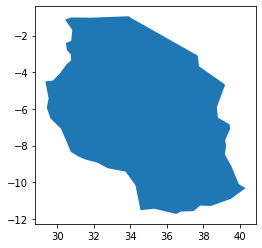

In [412]:
country.geometry.plot()

In [413]:
country_bbox_splitter = sh.BBoxSplitter(country.geometry.to_list(),sh.CRS.WGS84,(bbox_num_y,bbox_num_x))

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [414]:
geometry = [Polygon(bbox.get_polygon()) for bbox in country_bbox_splitter.get_bbox_list()]
country_bbox = gpd.GeoDataFrame(crs=country.crs, geometry=geometry)

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [415]:
fig, ax = plt.subplots(figsize=(400, 400))

country_bbox.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.4)

country.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)

ax.set_title('Bboxes', fontsize=25)

plt.savefig('country_tanzania.png')

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [462]:
aglomerado = [point for i, point in portugal_gdf.iterrows() if gpd.GeoSeries(point).within(portugal_bounds)]

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:     You are passing non-geometry data to the GeoSeries constructor. Currently,
    it falls back to returning a pandas Series. But in the future, we will start
    to raise a TypeError instead.
  """Entry point for launching an IPython kernel.


AttributeError: 'Series' object has no attribute 'within'

In [466]:
aglomerado = gpd.GeoDataFrame()
for i, point in portugal_gdf.iterrows():
    if(point.geometry.within(portugal_bounds)):
        aglomerado.append(point)

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'GeoSeries' object has no attribute '_geom'

In [478]:
portugal_gdf.apply(check_if_is_inside_poly,result_type="reduce")

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: (<class 'geopandas.geoseries.GeoSeries'>, <class 'pandas.core.series.Series'>)

In [477]:
def check_if_is_inside_poly(x):
    return portugal_bounds.contains(x)

In [493]:
portugal_bounds = gpd.GeoDataFrame(geometry=portugal_bounds, crs=sh.CRS.WGS84.pyproj_crs())

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [502]:
dataset_points = gpd.sjoin(portugal_gdf,portugal_bounds,op="within",how="left").drop("index_right", axis="columns")

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [537]:
bbox_with_data2 = gpd.sjoin(gdf_bbox,portugal_gdf,op='overlaps',how='inner')
bbox_with_data2.append(gpd.sjoin(gdf_bbox,portugal_gdf,op='contains',how='inner'))


C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


geometry  index_right      ID  \
357    POLYGON ((-9.29524 39.31529, -9.29524 39.33260...           47   37945   
358    POLYGON ((-9.29524 39.33260, -9.29524 39.34991...           47   37945   
451    POLYGON ((-9.24487 38.64015, -9.24487 38.65746...            8  121345   
503    POLYGON ((-9.22808 38.64015, -9.22808 38.65746...            8  121345   
613    POLYGON ((-9.19450 38.46704, -9.19450 38.48435...            7  195169   
...                                                  ...          ...     ...   
32881  POLYGON ((-6.32346 41.54843, -6.32346 41.56574...         3238  108354   
32884  POLYGON ((-6.32346 41.60036, -6.32346 41.61767...         3258  184807   
32895  POLYGON ((-6.30667 41.53111, -6.30667 41.54843...         3257  100532   
32901  POLYGON ((-6.30667 41.63498, -6.30667 41.65229...         3278   92000   
32945  POLYGON ((-6.20593 41.56574, -6.20593 41.58305...         3331  158531   

       POINT_ID  YEAR NUTS0 NUTS1 NUTS2  NUTS3     TH_LAT  ...  REVISIT  \
357    26682016  2018    PT   PT1  PT16  PT16B  39.332989  ...        1   
358    26682016  2018    PT   PT1  PT16  PT16B  39.332989  ...        1   
451    26561940  2018    PT   PT1  PT17  PT170  38.641593  ...        4   
503    26561940  2018    PT   PT1  PT17  PT170  38.641593  ...        4   
613    26561922  2018    PT   PT1  PT17  PT170  38.484174  ...        4   
...         ...   ...   ...   ...   ...    ...        ...  ...      ...   
32881  29662198  2018    PT   PT1  PT11  PT11E  41.558566  ...        4   
32884  29682204  2018    PT   PT1  PT11  PT11E  41.615255  ...        4   
32895  29682196  2018    PT   PT1  PT11  PT11E  41.544847  ...        3   
32901  29702206  2018    PT   PT1  PT11  PT11E  41.636739  ...        4   
32945  29762198  2018    PT   PT1  PT11  PT11E  41.577929  ...        3   

       TH_GPS_DIST                              FILE_PATH_GISCO_NORTH  \
357       1.370346  https://gisco-services.ec.europa.eu/lucas/phot...   
358       1.370346  https://gisco-services.ec.europa.eu/lucas/phot...   
451       0.629488  https://gisco-services.ec.europa.eu/lucas/phot...   
503       0.629488  https://gisco-services.ec.europa.eu/lucas/phot...   
613       0.922335  https://gisco-services.ec.europa.eu/lucas/phot...   
...            ...                                                ...   
32881     0.748799  https://gisco-services.ec.europa.eu/lucas/phot...   
32884     0.615616  https://gisco-services.ec.europa.eu/lucas/phot...   
32895     0.799738  https://gisco-services.ec.europa.eu/lucas/phot...   
32901     0.891249  https://gisco-services.ec.europa.eu/lucas/phot...   
32945     0.479976  https://gisco-services.ec.europa.eu/lucas/phot...   

                                   FILE_PATH_GISCO_SOUTH  \
357    https://gisco-services.ec.europa.eu/lucas/phot...   
358    https://gisco-services.ec.europa.eu/lucas/phot...   
451    https://gisco-services.ec.europa.eu/lucas/phot...   
503    https://gisco-services.ec.europa.eu/lucas/phot...   
613    https://gisco-services.ec.europa.eu/lucas/phot...   
...                                                  ...   
32881  https://gisco-services.ec.europa.eu/lucas/phot...   
32884  https://gisco-services.ec.europa.eu/lucas/phot...   
32895  https://gisco-services.ec.europa.eu/lucas/phot...   
32901  https://gisco-services.ec.europa.eu/lucas/phot...   
32945  https://gisco-services.ec.europa.eu/lucas/phot...   

                                    FILE_PATH_GISCO_EAST  \
357    https://gisco-services.ec.europa.eu/lucas/phot...   
358    https://gisco-services.ec.europa.eu/lucas/phot...   
451    https://gisco-services.ec.europa.eu/lucas/phot...   
503    https://gisco-services.ec.europa.eu/lucas/phot...   
613    https://gisco-services.ec.europa.eu/lucas/phot...   
...                                                  ...   
32881  https://gisco-services.ec.europa.eu/lucas/phot...   
32884  https://gisco-services.ec.europa.eu/lucas/phot...   
32895  https://gisco-services.ec.eur

In [538]:
1940-1587

C:\Users\FEEL\anaconda3\envs\Geospatial\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


353